# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

In [2]:
#from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [3]:
tab = pandas.read_csv('line_fitting.csv')
print(tab.columns)

Index(['Unnamed: 0', 'x', 'y', 'y_err'], dtype='object')


Text(0, 0.5, 'y')

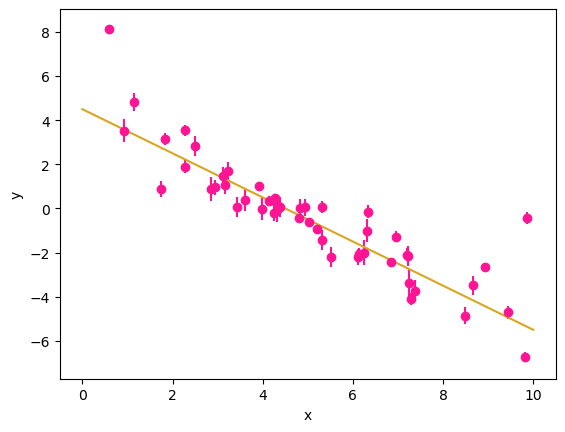

In [10]:
plt.errorbar(tab['x'], tab['y'], yerr=tab['y_err'], fmt='o', c='deeppink')
x_rng = np.arange(0,11)
plt.plot(x_rng, -1*x_rng + 4.5, c='goldenrod')
plt.xlabel('x')
plt.ylabel('y')

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

In [31]:
import emcee
from scipy.optimize import minimize
import corner

In [64]:
## fit the data using an ensemble sampler

# explicitly write down the likelihood function
# This likelihood function is simply a Gaussian where the variance is underestimated by some fractional amount: 
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2# + model**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2)# + np.log(sigma2))

def log_prior(theta):
    m, b = theta
    # I think that the slope is ~-1 and intercept is ~4.5
    # -> dont allow positive or very negative slope
    # -> generic bounds for b and log_f
    if -10 < m < 0 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [65]:
# to know where to initialize, get a sense of maximum likelihood result
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([-1, 4.5]) + 0.1 * np.random.randn(1)
soln = minimize(nll, initial, args=(tab['x'], tab['y'], tab['y_err']))
m_ml, b_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

Maximum likelihood estimates:
m = -1.104
b = 5.441


In [66]:
# use MLE result to define starting positions for the ensemble of walkers
pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(tab['x'], tab['y'], tab['y_err'])
)
sampler.run_mcmc(pos, 5000, progress=True);

You must install the tqdm library to use progress indicators with emcee


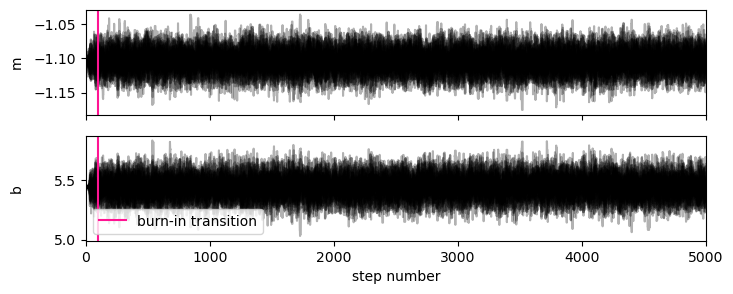

In [67]:
fig, axes = plt.subplots(2, figsize=(8, 3), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axvline(100, c='deeppink', label='burn-in transition')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].legend()
axes[-1].set_xlabel("step number");

In [68]:
tau = sampler.get_autocorr_time()
print(tau)

[30.82979975 30.84953077]


(9792, 2)


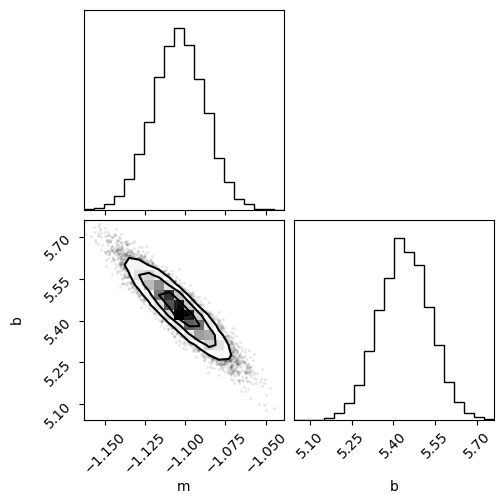

In [69]:
# account for burnin and thin (thin=15 informed by autocorr, ~half the autocorr time)
flat_samples = sampler.get_chain(discard=100, thin=int(33/2), flat=True)
print(flat_samples.shape)

corner.corner(
    flat_samples, labels=labels);

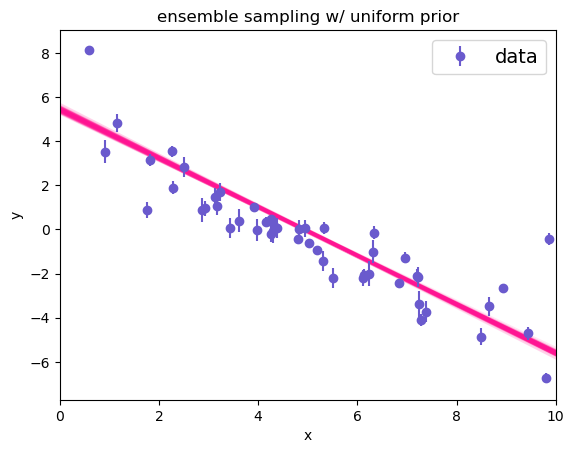

In [70]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_rng, np.dot(np.vander(x_rng, 2), sample[:2]), c='deeppink', alpha=0.1)
plt.errorbar(tab['x'], tab['y'], yerr=tab['y_err'], fmt="o", c='slateblue', label='data')
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.title('ensemble sampling w/ uniform prior')
plt.xlabel("x")
plt.ylabel("y");

In [7]:
x, y, y_err = tab.x.values, tab.y.values, tab.y_err.values

In [ ]:
## fit the data using HMC / NUTS
import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer

numpyro.set_host_device_count(2)


def linear_model(x, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0, 1))

    # Transformed parameters (and other things!) can be tracked during sampling using
    # "deterministics" as follows:
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))

    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(m * x + b, yerr), obs=y)


/Users/saarahhall/miniconda3/envs/jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(linear_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), x, y_err, y=y)

Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 2.67 s, sys: 165 ms, total: 2.84 s
Wall time: 2.88 s


Running chain 0:   0%|          | 0/4000 [00:02<?, ?it/s]

Running chain 1: 100%|██████████| 4000/4000 [00:02<00:00, 1586.54it/s]


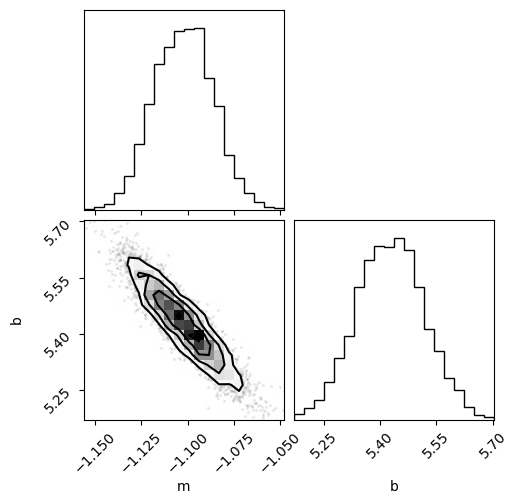

In [11]:
import corner
import arviz as az

inf_data = az.from_numpyro(sampler)
corner.corner(inf_data, var_names=["m", "b"]);

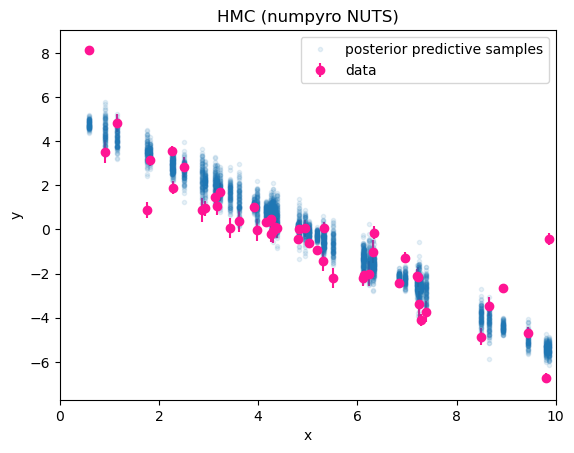

In [14]:
post_pred_samples = infer.Predictive(linear_model, sampler.get_samples())(
    jax.random.PRNGKey(1), x, y_err
)
post_pred_y = post_pred_samples["y"]

plt.errorbar(x, y, yerr=y_err, fmt="o", c='deeppink', label='data')
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.title('HMC (numpyro NUTS)')
plt.xlabel("x")
plt.ylabel("y");

label = "posterior predictive samples"
for n in np.random.default_rng(0).integers(len(post_pred_y), size=100):
    plt.plot(x, post_pred_y[n], ".", color="C0", alpha=0.1, label=label)
    label = None
plt.legend();

In [ ]:
## fit the data using nested sampling

# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.